In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_wr_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

12960


### Split data into train/test/validation

In [5]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

12960


In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']

# FOUND USING RFE IN RESEARCH NOTEBOOK
#features = ['6GameRecTargetsPerTeamPlay','6GameRecYardsPerTeamPlay','CareerAvgRecYards',
#            'CareerRecYardsPerTeamPlay','SeasonAvgRecYards','SeasonAvgReceptions','SeasonRecTargetsPerTeamPlay',
#            'SeasonRecYardsPerTeamPlay','SeasonTeamPassYardsPerCompAllowed']

all_features = features + [target_variable]

In [8]:
train_test_data = raw_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [9]:
X.shape

(12960, 539)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.3820427339761634, 'gamma': 0.16860328778287603, 'learning_rate': 0.06713678592573274, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 120, 'reg_alpha': 0.11428576999797946, 'reg_lambda': 7.649009724592773, 'subsample': 0.8394488625389203}
Best Score (R-squared): 0.265234448310383
Test R-squared: 0.26291437406175255
Test RMSE: 31.6278
Test MAE: 24.4766


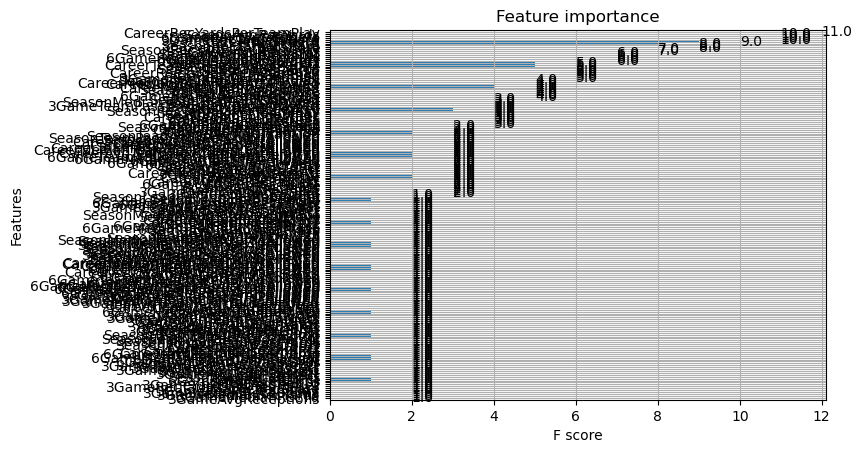

,TargetRecYards,pred_TargetRecYards,residuals
6407,62.0,37.276089,24.723911
6301,43.0,53.510368,-10.510368
304,0.0,20.878391,-20.878391
12520,82.0,43.898952,38.101048
2417,46.0,56.229836,-10.229836


In [10]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=500, 
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()

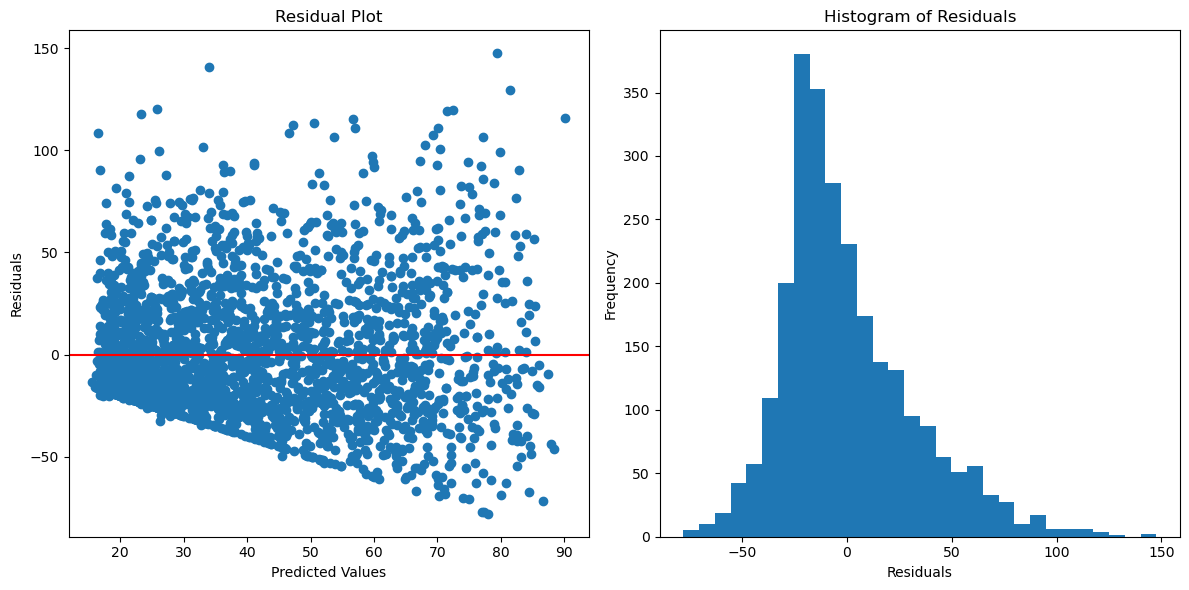

In [11]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

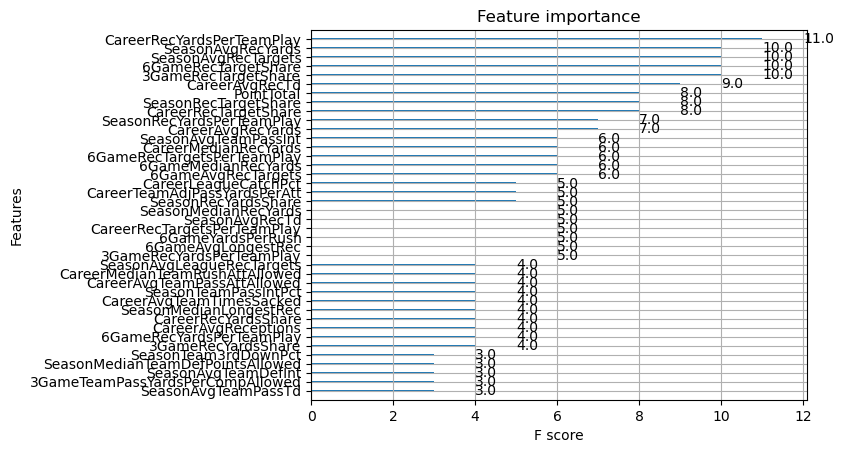

<Figure size 1800x1200 with 0 Axes>

In [12]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

### Persist the best model in the models dir

In [13]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_wr_prod.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_wr_prod.pkl']

In [14]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_wr_prod.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

In [16]:
X_test.loc[0]

3GameAvgLongestRec                       28.666667
3GameAvgRecTargets                        4.666667
3GameAvgRecTd                             0.000000
3GameAvgRecYards                         44.666667
3GameAvgReceptions                        3.000000
3GameCatchPct                             0.642857
3GameMedianLongestRec                    32.000000
3GameMedianRecTargets                     5.000000
3GameMedianRecTd                          0.000000
3GameMedianRecYards                      41.000000
3GameMedianReceptions                     3.000000
3GameRecPerTeamPlay                       0.047120
3GameRecShare                             0.123288
3GameRecTargetShare                       0.122807
3GameRecTargetsPerTeamPlay                0.073298
3GameRecYardsPerTeamPlay                  0.701571
3GameRecYardsShare                        0.170701
3GameYardsPerRecTarget                    9.571429
3GameYardsPerRush                        14.888889
6GameAvgLongestRec             

In [21]:
X_test.loc[0].to_dict()

{'3GameAvgLongestRec': 28.666666666666668,
 '3GameAvgRecTargets': 4.666666666666667,
 '3GameAvgRecTd': 0.0,
 '3GameAvgRecYards': 44.66666666666666,
 '3GameAvgReceptions': 3.0,
 '3GameCatchPct': 0.6428571428571429,
 '3GameMedianLongestRec': 32.0,
 '3GameMedianRecTargets': 5.0,
 '3GameMedianRecTd': 0.0,
 '3GameMedianRecYards': 41.0,
 '3GameMedianReceptions': 3.0,
 '3GameRecPerTeamPlay': 0.0471204188481675,
 '3GameRecShare': 0.1232876712328767,
 '3GameRecTargetShare': 0.1228070175438596,
 '3GameRecTargetsPerTeamPlay': 0.0732984293193717,
 '3GameRecYardsPerTeamPlay': 0.7015706806282722,
 '3GameRecYardsShare': 0.1707006369426751,
 '3GameYardsPerRecTarget': 9.571428571428571,
 '3GameYardsPerRush': 14.88888888888889,
 '6GameAvgLongestRec': 28.0,
 '6GameAvgRecTargets': 5.333333333333333,
 '6GameAvgRecTd': 0.3333333333333333,
 '6GameAvgRecYards': 49.333333333333336,
 '6GameAvgReceptions': 3.6666666666666665,
 '6GameCatchPct': 0.6875,
 '6GameMedianLongestRec': 30.0,
 '6GameMedianRecTargets': 5.5

In [26]:
test = pd.DataFrame({'3GameAvgLongestRec': {170: 30.33333333333333},
 '3GameAvgRecTargets': {170: 3.0},
 '3GameAvgRecTd': {170: 0.6666666666666666},
 '3GameAvgRecYards': {170: 47.66666666666666},
 '3GameAvgReceptions': {170: 2.6666666666666665},
 '3GameCatchPct': {170: 0.8888888888888888},
 '3GameMedianLongestRec': {170: 18.0},
 '3GameMedianRecTargets': {170: 3.0},
 '3GameMedianRecTd': {170: 1.0},
 '3GameMedianRecYards': {170: 44.0},
 '3GameMedianReceptions': {170: 2.0},
 '3GameRecPerTeamPlay': {170: 0.0416666666666666},
 '3GameRecShare': {170: 0.1025641025641025},
 '3GameRecTargetShare': {170: 0.0841121495327102},
 '3GameRecTargetsPerTeamPlay': {170: 0.046875},
 '3GameRecYardsPerTeamPlay': {170: 0.7447916666666666},
 '3GameRecYardsShare': {170: 0.1556039173014145},
 '3GameYardsPerRecTarget': {170: 15.88888888888889},
 '3GameYardsPerRush': {170: 17.875},
 '6GameAvgLongestRec': {170: 26.166666666666668},
 '6GameAvgRecTargets': {170: 2.833333333333333},
 '6GameAvgRecTd': {170: 0.5},
 '6GameAvgRecYards': {170: 37.66666666666666},
 '6GameAvgReceptions': {170: 2.1666666666666665},
 '6GameCatchPct': {170: 0.7647058823529411},
 '6GameMedianLongestRec': {170: 21.0},
 '6GameMedianRecTargets': {170: 2.5},
 '6GameMedianRecTd': {170: 0.5},
 '6GameMedianRecYards': {170: 36.5},
 '6GameMedianReceptions': {170: 2.0},
 '6GameRecPerTeamPlay': {170: 0.0328282828282828},
 '6GameRecShare': {170: 0.0833333333333333},
 '6GameRecTargetShare': {170: 0.0769230769230769},
 '6GameRecTargetsPerTeamPlay': {170: 0.0429292929292929},
 '6GameRecYardsPerTeamPlay': {170: 0.5707070707070707},
 '6GameRecYardsShare': {170: 0.1289954337899543},
 '6GameYardsPerRecTarget': {170: 13.294117647058824},
 '6GameYardsPerRush': {170: 17.384615384615383},
 'CareerAvgLongestRec': {170: 23.88235294117647},
 'CareerAvgRecTargets': {170: 5.5},
 'CareerAvgRecTd': {170: 0.2941176470588235},
 'CareerAvgRecYards': {170: 38.88235294117647},
 'CareerAvgReceptions': {170: 3.4411764705882355},
 'CareerCatchPct': {170: 0.6256684491978609},
 'CareerMedianLongestRec': {170: 19.0},
 'CareerMedianRecTargets': {170: 5.0},
 'CareerMedianRecTd': {170: 0.0},
 'CareerMedianRecYards': {170: 32.5},
 'CareerMedianReceptions': {170: 3.0},
 'CareerPerRecTarget': {170: 7.06951871657754},
 'CareerRecPerTeamPlay': {170: 0.0529651425984608},
 'CareerRecShare': {170: 0.1402877697841726},
 'CareerRecTargetShare': {170: 0.1508064516129032},
 'CareerRecTargetsPerTeamPlay': {170: 0.0846536894522408},
 'CareerRecYardsPerTeamPlay': {170: 0.5984608420099593},
 'CareerRecYardsShare': {170: 0.1462227629686981},
 'CareerYardsPerRec': {170: 11.2991452991453},
 'SeasonAvgLongestRec': {170: 26.6},
 'SeasonAvgRecTargets': {170: 2.2},
 'SeasonAvgRecTd': {170: 0.6},
 'SeasonAvgRecYards': {170: 37.0},
 'SeasonAvgReceptions': {170: 2.0},
 'SeasonCatchPct': {170: 0.9090909090909092},
 'SeasonMedianLongestRec': {170: 19.0},
 'SeasonMedianRecTargets': {170: 2.0},
 'SeasonMedianRecTd': {170: 1.0},
 'SeasonMedianRecYards': {170: 32.0},
 'SeasonMedianReceptions': {170: 2.0},
 'SeasonPerRecTarget': {170: 16.818181818181817},
 'SeasonRecPerTeamPlay': {170: 0.0303951367781155},
 'SeasonRecShare': {170: 0.078125},
 'SeasonRecTargetShare': {170: 0.0628571428571428},
 'SeasonRecTargetsPerTeamPlay': {170: 0.033434650455927},
 'SeasonRecYardsPerTeamPlay': {170: 0.5623100303951368},
 'SeasonRecYardsShare': {170: 0.1282940360610263},
 'SeasonYardsPerRec': {170: 18.5},
 '3GameAvgTeamNetPassYards': {170: 297.3333333333333},
 '3GameAvgTeamPassAtt': {170: 35.666666666666664},
 '3GameAvgTeamPassComp': {170: 26.0},
 '3GameAvgTeamPassInt': {170: 0.3333333333333333},
 '3GameAvgTeamPassTd': {170: 2.333333333333333},
 '3GameAvgTeamPassYards': {170: 306.3333333333333},
 '3GameAvgTeamSackYardsLost': {170: 9.0},
 '3GameAvgTeamTimesSacked': {170: 1.6666666666666667},
 '3GameMedianTeamNetPassYards': {170: 297.0},
 '3GameMedianTeamPassAtt': {170: 32.0},
 '3GameMedianTeamPassComp': {170: 24.0},
 '3GameMedianTeamPassInt': {170: 0.0},
 '3GameMedianTeamPassTd': {170: 2.0},
 '3GameMedianTeamPassYards': {170: 311.0},
 '3GameMedianTeamSackYardsLost': {170: 12.0},
 '3GameMedianTeamTimesSacked': {170: 2.0},
 '3GameTeamAdjPassYardsPerAtt': {170: 9.476635514018692},
 '3GameTeamPassCompPct': {170: 0.7289719626168224},
 '3GameTeamPassIntPct': {170: 0.0093457943925233},
 '3GameTeamPassTdPct': {170: 0.0654205607476635},
 '3GameTeamPassYardsPerAtt': {170: 8.588785046728972},
 '3GameTeamPassYardsPerComp': {170: 11.782051282051285},
 '6GameAvgTeamNetPassYards': {170: 278.4},
 '6GameAvgTeamPassAtt': {170: 35.0},
 '6GameAvgTeamPassComp': {170: 25.6},
 '6GameAvgTeamPassInt': {170: 0.2},
 '6GameAvgTeamPassTd': {170: 2.2},
 '6GameAvgTeamPassYards': {170: 288.4},
 '6GameAvgTeamSackYardsLost': {170: 10.0},
 '6GameAvgTeamTimesSacked': {170: 1.6},
 '6GameMedianTeamNetPassYards': {170: 261.0},
 '6GameMedianTeamPassAtt': {170: 32.0},
 '6GameMedianTeamPassComp': {170: 24.0},
 '6GameMedianTeamPassInt': {170: 0.0},
 '6GameMedianTeamPassTd': {170: 2.0},
 '6GameMedianTeamPassYards': {170: 284.0},
 '6GameMedianTeamSackYardsLost': {170: 12.0},
 '6GameMedianTeamTimesSacked': {170: 2.0},
 '6GameTeamAdjPassYardsPerAtt': {170: 9.24},
 '6GameTeamPassCompPct': {170: 0.7314285714285714},
 '6GameTeamPassIntPct': {170: 0.0057142857142857},
 '6GameTeamPassTdPct': {170: 0.0628571428571428},
 '6GameTeamPassYardsPerAtt': {170: 8.24},
 '6GameTeamPassYardsPerComp': {170: 11.265625},
 'CareerAvgTeamNetPassYards': {170: 278.4},
 'CareerAvgTeamPassAtt': {170: 35.0},
 'CareerAvgTeamPassComp': {170: 25.6},
 'CareerAvgTeamPassInt': {170: 0.2},
 'CareerAvgTeamPassTd': {170: 2.2},
 'CareerAvgTeamPassYards': {170: 288.4},
 'CareerAvgTeamSackYardsLost': {170: 10.0},
 'CareerAvgTeamTimesSacked': {170: 1.6},
 'CareerMedianTeamNetPassYards': {170: 261.0},
 'CareerMedianTeamPassAtt': {170: 32.0},
 'CareerMedianTeamPassComp': {170: 24.0},
 'CareerMedianTeamPassInt': {170: 0.0},
 'CareerMedianTeamPassTd': {170: 2.0},
 'CareerMedianTeamPassYards': {170: 284.0},
 'CareerMedianTeamSackYardsLost': {170: 12.0},
 'CareerMedianTeamTimesSacked': {170: 2.0},
 'CareerTeamAdjPassYardsPerAtt': {170: 9.24},
 'CareerTeamPassCompPct': {170: 0.7314285714285714},
 'CareerTeamPassIntPct': {170: 0.0057142857142857},
 'CareerTeamPassTdPct': {170: 0.0628571428571428},
 'CareerTeamPassYardsPerAtt': {170: 8.24},
 'CareerTeamPassYardsPerComp': {170: 11.265625},
 'SeasonAvgTeamNetPassYards': {170: 278.4},
 'SeasonAvgTeamPassAtt': {170: 35.0},
 'SeasonAvgTeamPassComp': {170: 25.6},
 'SeasonAvgTeamPassInt': {170: 0.2},
 'SeasonAvgTeamPassTd': {170: 2.2},
 'SeasonAvgTeamPassYards': {170: 288.4},
 'SeasonAvgTeamSackYardsLost': {170: 10.0},
 'SeasonAvgTeamTimesSacked': {170: 1.6},
 'SeasonMedianTeamNetPassYards': {170: 261.0},
 'SeasonMedianTeamPassAtt': {170: 32.0},
 'SeasonMedianTeamPassComp': {170: 24.0},
 'SeasonMedianTeamPassInt': {170: 0.0},
 'SeasonMedianTeamPassTd': {170: 2.0},
 'SeasonMedianTeamPassYards': {170: 284.0},
 'SeasonMedianTeamSackYardsLost': {170: 12.0},
 'SeasonMedianTeamTimesSacked': {170: 2.0},
 'SeasonTeamAdjPassYardsPerAtt': {170: 9.24},
 'SeasonTeamPassCompPct': {170: 0.7314285714285714},
 'SeasonTeamPassIntPct': {170: 0.0057142857142857},
 'SeasonTeamPassTdPct': {170: 0.0628571428571428},
 'SeasonTeamPassYardsPerAtt': {170: 8.24},
 'SeasonTeamPassYardsPerComp': {170: 11.265625},
 '3GameAvgTeamRushAtt': {170: 26.666666666666668},
 '3GameAvgTeamRushTd': {170: 0.6666666666666666},
 '3GameAvgTeamRushYards': {170: 118.66666666666669},
 '3GameMedianTeamRushAtt': {170: 23.0},
 '3GameMedianTeamRushTd': {170: 0.0},
 '3GameMedianTeamRushYards': {170: 126.0},
 '3GameTeamRushTdPct': {170: 0.025},
 '3GameTeamYardsPerRush': {170: 4.45},
 '6GameAvgTeamRushAtt': {170: 29.2},
 '6GameAvgTeamRushTd': {170: 1.2},
 '6GameAvgTeamRushYards': {170: 121.0},
 '6GameMedianTeamRushAtt': {170: 31.0},
 '6GameMedianTeamRushTd': {170: 1.0},
 '6GameMedianTeamRushYards': {170: 126.0},
 '6GameTeamRushTdPct': {170: 0.0410958904109589},
 '6GameTeamYardsPerRush': {170: 4.1438356164383565},
 'CareerAvgTeamRushAtt': {170: 29.2},
 'CareerAvgTeamRushTd': {170: 1.2},
 'CareerAvgTeamRushYards': {170: 121.0},
 'CareerMedianTeamRushAtt': {170: 31.0},
 'CareerMedianTeamRushTd': {170: 1.0},
 'CareerMedianTeamRushYards': {170: 126.0},
 'CareerTeamRushTdPct': {170: 0.0410958904109589},
 'CareerTeamYardsPerRush': {170: 4.1438356164383565},
 'SeasonAvgTeamRushAtt': {170: 29.2},
 'SeasonAvgTeamRushTd': {170: 1.2},
 'SeasonAvgTeamRushYards': {170: 121.0},
 'SeasonMedianTeamRushAtt': {170: 31.0},
 'SeasonMedianTeamRushTd': {170: 1.0},
 'SeasonMedianTeamRushYards': {170: 126.0},
 'SeasonTeamRushTdPct': {170: 0.0410958904109589},
 'SeasonTeamYardsPerRush': {170: 4.1438356164383565},
 '3GameAvgTeamLongestRec': {170: 178.33333333333334},
 '3GameAvgTeamRecTargets': {170: 35.333333333333336},
 '3GameAvgTeamRecTd': {170: 2.333333333333333},
 '3GameAvgTeamRecYards': {170: 306.3333333333333},
 '3GameAvgTeamReceptions': {170: 26.0},
 '3GameMedianTeamLongestRec': {170: 145.0},
 '3GameMedianTeamRecTargets': {170: 32.0},
 '3GameMedianTeamRecTd': {170: 2.0},
 '3GameMedianTeamRecYards': {170: 311.0},
 '3GameMedianTeamReceptions': {170: 24.0},
 '3GameTeamCatchPct': {170: 0.7358490566037735},
 '3GameTeamYardsPerRec': {170: 11.782051282051285},
 '3GameTeamYardsPerRecTarget': {170: 8.669811320754716},
 '6GameAvgTeamLongestRec': {170: 152.5},
 '6GameAvgTeamRecTargets': {170: 32.333333333333336},
 '6GameAvgTeamRecTd': {170: 2.0},
 '6GameAvgTeamRecYards': {170: 269.3333333333333},
 '6GameAvgTeamReceptions': {170: 24.83333333333333},
 '6GameMedianTeamLongestRec': {170: 146.0},
 '6GameMedianTeamRecTargets': {170: 31.5},
 '6GameMedianTeamRecTd': {170: 2.0},
 '6GameMedianTeamRecYards': {170: 272.5},
 '6GameMedianTeamReceptions': {170: 23.0},
 '6GameTeamCatchPct': {170: 0.7619047619047619},
 '6GameTeamYardsPerRec': {170: 11.265625},
 '6GameTeamYardsPerRecTarget': {170: 8.583333333333334},
 'CareerAvgTeamLongestRec': {170: 127.05954974582426},
 'CareerAvgTeamRecTargets': {170: 33.7356572258533},
 'CareerAvgTeamRecTd': {170: 1.625998547567175},
 'CareerAvgTeamRecYards': {170: 255.02106027596224},
 'CareerAvgTeamReceptions': {170: 22.501089324618736},
 'CareerMedianTeamLongestRec': {170: 125.0},
 'CareerMedianTeamRecTargets': {170: 33.0},
 'CareerMedianTeamRecTd': {170: 2.0},
 'CareerMedianTeamRecYards': {170: 249.0},
 'CareerMedianTeamReceptions': {170: 22.0},
 'CareerTeamCatchPct': {170: 0.7619047619047619},
 'CareerTeamYardsPerRec': {170: 11.265625},
 'CareerTeamYardsPerRecTarget': {170: 8.583333333333334},
 'SeasonAvgTeamLongestRec': {170: 128.03236245954693},
 'SeasonAvgTeamRecTargets': {170: 34.43042071197411},
 'SeasonAvgTeamRecTd': {170: 1.7378640776699028},
 'SeasonAvgTeamRecYards': {170: 262.546925566343},
 'SeasonAvgTeamReceptions': {170: 23.51779935275081},
 'SeasonMedianTeamLongestRec': {170: 127.0},
 'SeasonMedianTeamRecTargets': {170: 34.0},
 'SeasonMedianTeamRecTd': {170: 2.0},
 'SeasonMedianTeamRecYards': {170: 265.0},
 'SeasonMedianTeamReceptions': {170: 24.0},
 'SeasonTeamCatchPct': {170: 0.7619047619047619},
 'SeasonTeamYardsPerRec': {170: 11.265625},
 'SeasonTeamYardsPerRecTarget': {170: 8.583333333333334},
 '3GameAvgTeamDefFumbleRec': {170: 0.3333333333333333},
 '3GameAvgTeamDefFumbleRecTd': {170: 0.0},
 '3GameAvgTeamDefInt': {170: 1.3333333333333333},
 '3GameAvgTeamDefIntTd': {170: 0.3333333333333333},
 '3GameAvgTeamDefPointsAllowed': {170: 18.33333333333333},
 '3GameAvgTeamDefSacks': {170: 3.333333333333333},
 '3GameAvgTeamDefSafeties': {170: 0.0},
 '3GameAvgTeamNetPassYardsAllowed': {170: 197.66666666666663},
 '3GameAvgTeamPassAttAllowed': {170: 34.0},
 '3GameAvgTeamPassCompAllowed': {170: 22.0},
 '3GameAvgTeamPassIntAllowed': {170: 1.3333333333333333},
 '3GameAvgTeamPassTdAllowed': {170: 1.3333333333333333},
 '3GameAvgTeamPassYardsAllowed': {170: 231.0},
 '3GameAvgTeamRushAttAllowed': {170: 19.33333333333333},
 '3GameAvgTeamRushTdAllowed': {170: 0.6666666666666666},
 '3GameAvgTeamRushYardsAllowed': {170: 58.333333333333336},
 '3GameAvgTeamSackYardsLostAllowed': {170: 33.333333333333336},
 '3GameAvgTeamTimesSackedAllowed': {170: 3.333333333333333},
 '3GameAvgTeamToPAllowed': {170: 28.39},
 '3GameAvgTeamTotalPlaysAllowed': {170: 56.66666666666666},
 '3GameMedianTeamDefFumbleRec': {170: 0.0},
 '3GameMedianTeamDefFumbleRecTd': {170: 0.0},
 '3GameMedianTeamDefInt': {170: 1.0},
 '3GameMedianTeamDefIntTd': {170: 0.0},
 '3GameMedianTeamDefPointsAllowed': {170: 20.0},
 '3GameMedianTeamDefSacks': {170: 3.0},
 '3GameMedianTeamDefSafeties': {170: 0.0},
 '3GameMedianTeamNetPassYardsAllowed': {170: 208.0},
 '3GameMedianTeamPassAttAllowed': {170: 35.0},
 '3GameMedianTeamPassCompAllowed': {170: 20.0},
 '3GameMedianTeamPassIntAllowed': {170: 1.0},
 '3GameMedianTeamPassTdAllowed': {170: 1.0},
 '3GameMedianTeamPassYardsAllowed': {170: 243.0},
 '3GameMedianTeamRushAttAllowed': {170: 21.0},
 '3GameMedianTeamRushTdAllowed': {170: 1.0},
 '3GameMedianTeamRushYardsAllowed': {170: 46.0},
 '3GameMedianTeamSackYardsLostAllowed': {170: 35.0},
 '3GameMedianTeamTimesSackedAllowed': {170: 3.0},
 '3GameMedianTeamToPAllowed': {170: 28.47},
 '3GameMedianTeamTotalPlaysAllowed': {170: 59.0},
 '3GameTeamAdjPassYardsPerAttAllowed': {170: 5.813725490196078},
 '3GameTeamPassCompPctAllowed': {170: 0.6470588235294118},
 '3GameTeamPassIntPctAllowed': {170: 0.0392156862745098},
 '3GameTeamPassTdPctAllowed': {170: 0.0392156862745098},
 '3GameTeamPassYardsPerAttAllowed': {170: 6.794117647058823},
 '3GameTeamPassYardsPerCompAllowed': {170: 10.5},
 '3GameTeamRushTdPctAllowed': {170: 0.0344827586206896},
 '3GameTeamYardsPerRushAllowed': {170: 3.0172413793103448},
 '6GameAvgTeamDefFumbleRec': {170: 0.5},
 '6GameAvgTeamDefFumbleRecTd': {170: 0.0},
 '6GameAvgTeamDefInt': {170: 1.3333333333333333},
 '6GameAvgTeamDefIntTd': {170: 0.1666666666666666},
 '6GameAvgTeamDefPointsAllowed': {170: 18.33333333333333},
 '6GameAvgTeamDefSacks': {170: 3.6666666666666665},
 '6GameAvgTeamDefSafeties': {170: 0.1666666666666666},
 '6GameAvgTeamNetPassYardsAllowed': {170: 217.66666666666663},
 '6GameAvgTeamPassAttAllowed': {170: 35.666666666666664},
 '6GameAvgTeamPassCompAllowed': {170: 23.83333333333333},
 '6GameAvgTeamPassIntAllowed': {170: 1.3333333333333333},
 '6GameAvgTeamPassTdAllowed': {170: 1.1666666666666667},
 '6GameAvgTeamPassYardsAllowed': {170: 247.83333333333331},
 '6GameAvgTeamRushAttAllowed': {170: 21.666666666666668},
 '6GameAvgTeamRushTdAllowed': {170: 0.8333333333333334},
 '6GameAvgTeamRushYardsAllowed': {170: 64.33333333333333},
 '6GameAvgTeamSackYardsLostAllowed': {170: 30.166666666666668},
 '6GameAvgTeamTimesSackedAllowed': {170: 3.6666666666666665},
 '6GameAvgTeamToPAllowed': {170: 29.675},
 '6GameAvgTeamTotalPlaysAllowed': {170: 61.0},
 '6GameMedianTeamDefFumbleRec': {170: 0.0},
 '6GameMedianTeamDefFumbleRecTd': {170: 0.0},
 '6GameMedianTeamDefInt': {170: 1.5},
 '6GameMedianTeamDefIntTd': {170: 0.0},
 '6GameMedianTeamDefPointsAllowed': {170: 18.5},
 '6GameMedianTeamDefSacks': {170: 4.0},
 '6GameMedianTeamDefSafeties': {170: 0.0},
 '6GameMedianTeamNetPassYardsAllowed': {170: 198.5},
 '6GameMedianTeamPassAttAllowed': {170: 37.0},
 '6GameMedianTeamPassCompAllowed': {170: 22.5},
 '6GameMedianTeamPassIntAllowed': {170: 1.5},
 '6GameMedianTeamPassTdAllowed': {170: 1.0},
 '6GameMedianTeamPassYardsAllowed': {170: 236.0},
 '6GameMedianTeamRushAttAllowed': {170: 22.0},
 '6GameMedianTeamRushTdAllowed': {170: 1.0},
 '6GameMedianTeamRushYardsAllowed': {170: 64.0},
 '6GameMedianTeamSackYardsLostAllowed': {170: 31.0},
 '6GameMedianTeamTimesSackedAllowed': {170: 4.0},
 '6GameMedianTeamToPAllowed': {170: 29.925},
 '6GameMedianTeamTotalPlaysAllowed': {170: 60.0},
 '6GameTeamAdjPassYardsPerAttAllowed': {170: 5.640186915887851},
 '6GameTeamPassCompPctAllowed': {170: 0.6682242990654206},
 '6GameTeamPassIntPctAllowed': {170: 0.0373831775700934},
 '6GameTeamPassTdPctAllowed': {170: 0.0327102803738317},
 '6GameTeamPassYardsPerAttAllowed': {170: 6.9485981308411215},
 '6GameTeamPassYardsPerCompAllowed': {170: 10.398601398601398},
 '6GameTeamRushTdPctAllowed': {170: 0.0384615384615384},
 '6GameTeamYardsPerRushAllowed': {170: 2.9692307692307693},
 'CareerAvgTeamDefFumbleRec': {170: 0.631578947368421},
 'CareerAvgTeamDefFumbleRecTd': {170: 0.1052631578947368},
 'CareerAvgTeamDefInt': {170: 0.7631578947368421},
 'CareerAvgTeamDefIntTd': {170: 0.0789473684210526},
 'CareerAvgTeamDefPointsAllowed': {170: 25.18421052631579},
 'CareerAvgTeamDefSacks': {170: 2.8157894736842106},
 'CareerAvgTeamDefSafeties': {170: 0.0263157894736842},
 'CareerAvgTeamNetPassYardsAllowed': {170: 257.2894736842105},
 'CareerAvgTeamPassAttAllowed': {170: 37.13157894736842},
 'CareerAvgTeamPassCompAllowed': {170: 24.657894736842103},
 'CareerAvgTeamPassIntAllowed': {170: 0.7631578947368421},
 'CareerAvgTeamPassTdAllowed': {170: 1.868421052631579},
 'CareerAvgTeamPassYardsAllowed': {170: 276.7105263157895},
 'CareerAvgTeamRushAttAllowed': {170: 24.157894736842103},
 'CareerAvgTeamRushTdAllowed': {170: 0.9210526315789472},
 'CareerAvgTeamRushYardsAllowed': {170: 93.42105263157896},
 'CareerAvgTeamSackYardsLostAllowed': {170: 19.42105263157895},
 'CareerAvgTeamTimesSackedAllowed': {170: 2.8157894736842106},
 'CareerAvgTeamToPAllowed': {170: 29.666052631578943},
 'CareerAvgTeamTotalPlaysAllowed': {170: 64.10526315789474},
 'CareerMedianTeamDefFumbleRec': {170: 0.5},
 'CareerMedianTeamDefFumbleRecTd': {170: 0.0},
 'CareerMedianTeamDefInt': {170: 0.0},
 'CareerMedianTeamDefIntTd': {170: 0.0},
 'CareerMedianTeamDefPointsAllowed': {170: 26.0},
 'CareerMedianTeamDefSacks': {170: 2.5},
 'CareerMedianTeamDefSafeties': {170: 0.0},
 'CareerMedianTeamNetPassYardsAllowed': {170: 246.5},
 'CareerMedianTeamPassAttAllowed': {170: 36.0},
 'CareerMedianTeamPassCompAllowed': {170: 23.5},
 'CareerMedianTeamPassIntAllowed': {170: 0.0},
 'CareerMedianTeamPassTdAllowed': {170: 2.0},
 'CareerMedianTeamPassYardsAllowed': {170: 255.5},
 'CareerMedianTeamRushAttAllowed': {170: 23.5},
 'CareerMedianTeamRushTdAllowed': {170: 1.0},
 'CareerMedianTeamRushYardsAllowed': {170: 84.5},
 'CareerMedianTeamSackYardsLostAllowed': {170: 18.0},
 'CareerMedianTeamTimesSackedAllowed': {170: 2.5},
 'CareerMedianTeamToPAllowed': {170: 29.165},
 'CareerMedianTeamTotalPlaysAllowed': {170: 63.0},
 'CareerTeamAdjPassYardsPerAttAllowed': {170: 7.533664068036853},
 'CareerTeamPassCompPctAllowed': {170: 0.6640680368532955},
 'CareerTeamPassIntPctAllowed': {170: 0.0205527994330262},
 'CareerTeamPassTdPctAllowed': {170: 0.0503189227498228},
 'CareerTeamPassYardsPerAttAllowed': {170: 7.452161587526577},
 'CareerTeamPassYardsPerCompAllowed': {170: 11.221985058697973},
 'CareerTeamRushTdPctAllowed': {170: 0.0381263616557734},
 'CareerTeamYardsPerRushAllowed': {170: 3.867102396514161},
 'SeasonAvgTeamDefFumbleRec': {170: 0.5},
 'SeasonAvgTeamDefFumbleRecTd': {170: 0.0},
 'SeasonAvgTeamDefInt': {170: 1.3333333333333333},
 'SeasonAvgTeamDefIntTd': {170: 0.1666666666666666},
 'SeasonAvgTeamDefPointsAllowed': {170: 18.33333333333333},
 'SeasonAvgTeamDefSacks': {170: 3.6666666666666665},
 'SeasonAvgTeamDefSafeties': {170: 0.1666666666666666},
 'SeasonAvgTeamNetPassYardsAllowed': {170: 217.66666666666663},
 'SeasonAvgTeamPassAttAllowed': {170: 35.666666666666664},
 'SeasonAvgTeamPassCompAllowed': {170: 23.83333333333333},
 'SeasonAvgTeamPassIntAllowed': {170: 1.3333333333333333},
 'SeasonAvgTeamPassTdAllowed': {170: 1.1666666666666667},
 'SeasonAvgTeamPassYardsAllowed': {170: 247.83333333333331},
 'SeasonAvgTeamRushAttAllowed': {170: 21.666666666666668},
 'SeasonAvgTeamRushTdAllowed': {170: 0.8333333333333334},
 'SeasonAvgTeamRushYardsAllowed': {170: 64.33333333333333},
 'SeasonAvgTeamSackYardsLostAllowed': {170: 30.166666666666668},
 'SeasonAvgTeamTimesSackedAllowed': {170: 3.6666666666666665},
 'SeasonAvgTeamToPAllowed': {170: 29.675},
 'SeasonAvgTeamTotalPlaysAllowed': {170: 61.0},
 'SeasonMedianTeamDefFumbleRec': {170: 0.0},
 'SeasonMedianTeamDefFumbleRecTd': {170: 0.0},
 'SeasonMedianTeamDefInt': {170: 1.5},
 'SeasonMedianTeamDefIntTd': {170: 0.0},
 'SeasonMedianTeamDefPointsAllowed': {170: 18.5},
 'SeasonMedianTeamDefSacks': {170: 4.0},
 'SeasonMedianTeamDefSafeties': {170: 0.0},
 'SeasonMedianTeamNetPassYardsAllowed': {170: 198.5},
 'SeasonMedianTeamPassAttAllowed': {170: 37.0},
 'SeasonMedianTeamPassCompAllowed': {170: 22.5},
 'SeasonMedianTeamPassIntAllowed': {170: 1.5},
 'SeasonMedianTeamPassTdAllowed': {170: 1.0},
 'SeasonMedianTeamPassYardsAllowed': {170: 236.0},
 'SeasonMedianTeamRushAttAllowed': {170: 22.0},
 'SeasonMedianTeamRushTdAllowed': {170: 1.0},
 'SeasonMedianTeamRushYardsAllowed': {170: 64.0},
 'SeasonMedianTeamSackYardsLostAllowed': {170: 31.0},
 'SeasonMedianTeamTimesSackedAllowed': {170: 4.0},
 'SeasonMedianTeamToPAllowed': {170: 29.925},
 'SeasonMedianTeamTotalPlaysAllowed': {170: 60.0},
 'SeasonTeamAdjPassYardsPerAttAllowed': {170: 5.920560747663552},
 'SeasonTeamPassCompPctAllowed': {170: 0.6682242990654206},
 'SeasonTeamPassIntPctAllowed': {170: 0.0373831775700934},
 'SeasonTeamPassTdPctAllowed': {170: 0.0327102803738317},
 'SeasonTeamPassYardsPerAttAllowed': {170: 6.9485981308411215},
 'SeasonTeamPassYardsPerCompAllowed': {170: 10.398601398601398},
 'SeasonTeamRushTdPctAllowed': {170: 0.0384615384615384},
 'SeasonTeamYardsPerRushAllowed': {170: 2.9692307692307693},
 '3GameAvgTeam3rdDownAtt': {170: 12.333333333333334},
 '3GameAvgTeam3rdDownMade': {170: 6.0},
 '3GameAvgTeam4thDownAtt': {170: 1.3333333333333333},
 '3GameAvgTeam4thDownMade': {170: 1.0},
 '3GameAvgTeamToP': {170: 30.78333333333333},
 '3GameAvgTeamTotalPlays': {170: 64.0},
 '3GameMedianTeam3rdDownAtt': {170: 14.0},
 '3GameMedianTeam3rdDownMade': {170: 7.0},
 '3GameMedianTeam4thDownAtt': {170: 2.0},
 '3GameMedianTeam4thDownMade': {170: 1.0},
 '3GameMedianTeamToP': {170: 31.7},
 '3GameMedianTeamTotalPlays': {170: 67.0},
 '3GameTeam3rdDownPct': {170: 0.4864864864864865},
 '3GameTeam4thDownPct': {170: 0.75},
 '3GameTeamPassPlayPct': {170: 0.5572916666666666},
 '3GameTeamRushPlayPct': {170: 0.4166666666666667},
 '6GameAvgTeam3rdDownAtt': {170: 13.0},
 '6GameAvgTeam3rdDownMade': {170: 6.8},
 '6GameAvgTeam4thDownAtt': {170: 1.2},
 '6GameAvgTeam4thDownMade': {170: 1.0},
 '6GameAvgTeamToP': {170: 31.97},
 '6GameAvgTeamTotalPlays': {170: 65.8},
 '6GameMedianTeam3rdDownAtt': {170: 14.0},
 '6GameMedianTeam3rdDownMade': {170: 7.0},
 '6GameMedianTeam4thDownAtt': {170: 2.0},
 '6GameMedianTeam4thDownMade': {170: 1.0},
 '6GameMedianTeamToP': {170: 31.7},
 '6GameMedianTeamTotalPlays': {170: 67.0},
 '6GameTeam3rdDownPct': {170: 0.5230769230769231},
 '6GameTeam4thDownPct': {170: 0.8333333333333334},
 '6GameTeamPassPlayPct': {170: 0.5319148936170213},
 '6GameTeamRushPlayPct': {170: 0.4437689969604863},
 'CareerAvgTeam3rdDownAtt': {170: 13.0},
 'CareerAvgTeam3rdDownMade': {170: 6.8},
 'CareerAvgTeam4thDownAtt': {170: 1.2},
 'CareerAvgTeam4thDownMade': {170: 1.0},
 'CareerAvgTeamToP': {170: 31.97},
 'CareerAvgTeamTotalPlays': {170: 65.8},
 'CareerMedianTeam3rdDownAtt': {170: 14.0},
 'CareerMedianTeam3rdDownMade': {170: 7.0},
 'CareerMedianTeam4thDownAtt': {170: 2.0},
 'CareerMedianTeam4thDownMade': {170: 1.0},
 'CareerMedianTeamToP': {170: 31.7},
 'CareerMedianTeamTotalPlays': {170: 67.0},
 'CareerTeam3rdDownPct': {170: 0.5230769230769231},
 'CareerTeam4thDownPct': {170: 0.8333333333333334},
 'CareerTeamPassPlayPct': {170: 0.5319148936170213},
 'CareerTeamRushPlayPct': {170: 0.4437689969604863},
 'SeasonAvgTeam3rdDownAtt': {170: 13.0},
 'SeasonAvgTeam3rdDownMade': {170: 6.8},
 'SeasonAvgTeam4thDownAtt': {170: 1.2},
 'SeasonAvgTeam4thDownMade': {170: 1.0},
 'SeasonAvgTeamToP': {170: 31.97},
 'SeasonAvgTeamTotalPlays': {170: 65.8},
 'SeasonMedianTeam3rdDownAtt': {170: 14.0},
 'SeasonMedianTeam3rdDownMade': {170: 7.0},
 'SeasonMedianTeam4thDownAtt': {170: 2.0},
 'SeasonMedianTeam4thDownMade': {170: 1.0},
 'SeasonMedianTeamToP': {170: 31.7},
 'SeasonMedianTeamTotalPlays': {170: 67.0},
 'SeasonTeam3rdDownPct': {170: 0.5230769230769231},
 'SeasonTeam4thDownPct': {170: 0.8333333333333334},
 'SeasonTeamPassPlayPct': {170: 0.5319148936170213},
 'SeasonTeamRushPlayPct': {170: 0.4437689969604863},
 '3GameAvgLeagueLongestRec': {170: 127.08306709265176},
 '3GameAvgLeagueRecTargets': {170: 33.61022364217252},
 '3GameAvgLeagueRecTd': {170: 1.6166134185303511},
 '3GameAvgLeagueRecYards': {170: 253.80670926517573},
 '3GameAvgLeagueReceptions': {170: 22.339456869009584},
 '3GameLeagueCatchPct': {170: 0.639795918367347},
 '3GameLeagueYardsPerRec': {170: 11.18341307814992},
 '3GameLeagueYardsPerRecTarget': {170: 7.155102040816327},
 '6GameAvgLeagueLongestRec': {170: 127.0525078369906},
 '6GameAvgLeagueRecTargets': {170: 33.60971786833856},
 '6GameAvgLeagueRecTd': {170: 1.6206896551724137},
 '6GameAvgLeagueRecYards': {170: 254.2100313479624},
 '6GameAvgLeagueReceptions': {170: 22.372257053291538},
 '6GameLeagueCatchPct': {170: 0.6513614522156967},
 '6GameLeagueYardsPerRec': {170: 11.348360655737704},
 '6GameLeagueYardsPerRecTarget': {170: 7.391884676988788},
 'CareerAvgLeagueLongestRec': {170: 127.08306709265176},
 'CareerAvgLeagueRecTargets': {170: 33.61022364217252},
 'CareerAvgLeagueRecTd': {170: 1.6166134185303511},
 'CareerAvgLeagueRecYards': {170: 253.80670926517573},
 'CareerAvgLeagueReceptions': {170: 22.339456869009584},
 'CareerLeagueCatchPct': {170: 0.6646625475285171},
 'CareerLeagueYardsPerRec': {170: 11.361364367692802},
 'CareerLeagueYardsPerRecTarget': {170: 7.551473384030419},
 'SeasonAvgLeagueLongestRec': {170: 128.85326086956522},
 'SeasonAvgLeagueRecTargets': {170: 34.04891304347826},
 'SeasonAvgLeagueRecTd': {170: 1.75},
 'SeasonAvgLeagueRecYards': {170: 259.3967391304348},
 'SeasonAvgLeagueReceptions': {170: 23.108695652173918},
 'SeasonLeagueCatchPct': {170: 0.6786911412609736},
 'SeasonLeagueYardsPerRec': {170: 11.225070555032923},
 'SeasonLeagueYardsPerRecTarget': {170: 7.618355945730247},
 'PointTotal': {170: 51.5},
 'Moneyline': {170: 2.7199999999999998},
 'HomeFlag': {170: 1.0}})

In [27]:
best_xgb.predict(test)

array([29.772882], dtype=float32)